In [37]:
#import chandra
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from astropy.table import Table, join
import numpy as np
from astropy.coordinates import SkyCoord,Angle
from astropy import units as u
import astropy
from astropy.time import Time
from astropy.coordinates import EarthLocation
#import astroplan
from astropy.wcs import WCS
from matplotlib.colors import LogNorm

import glob
import pyphot
from tqdm import tqdm

import sys
sys.path.append('../')
import WD_models

sys.path.append('../corv/src')
import corv

sys.path.append('../wdphoto/src')
import wdphoto

%config InlineBackend.figure_format='retina'
plt.style.use('stefan.mplstyle')

radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16
speed_light = 299792458 #m/s

In [38]:
#from dustmaps.config import config
#config['data_dir'] = '/home/sarsene1/.dustmaps'

#import dustmaps.edenhofer2023
#dustmaps.edenhofer2023.fetch()

In [39]:
catalog = Table.read('five_observable.csv')

In [40]:
catalog[['wd_source_id', 'wd_ra', 'wd_dec', 'radial_velocity']]

wd_source_id,wd_ra,wd_dec,radial_velocity
int64,float64,float64,float64
6844676417977418880,324.61175391863975,-12.013100693381624,3.18015193939209
3121385658671190784,92.21438403314589,-0.9974533046455966,28.799100875854492
6240588103859479680,236.83192466668007,-22.47579134532418,--
5786316972105722880,206.49862295133764,-78.57258007813462,32.200538635253906
4689934412696732416,6.791408582156655,-71.03033225844172,57.53017044067383


In [41]:
reference = {'wd_source_id' : [3121385658671190784, 6240588103859479680], 
             'wd_specfile' : ['data/j0608m0059_coadd.fits', 'data/j1657m5438_coadd.fits']}

ref_tab = Table(reference)
catalog = join(catalog, ref_tab, keys = 'wd_source_id', join_type='outer')
catalog

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [47]:
catalog['wd_rv'] = -999*np.ones(len(catalog))
catalog['wd_e_rv'] = -999*np.ones(len(catalog))
catalog['wd_redchi'] = -999*np.ones(len(catalog))

plots = []
plot = False

for i in tqdm(range(len(catalog))):
    if catalog['wd_specfile'][i] != '':
        f = fits.open(catalog['wd_specfile'][i])
    else:
        catalog['wd_rv'][i] = np.nan
        catalog['wd_e_rv'][i] = np.nan
        catalog['wd_redchi'][i] = np.nan

        continue
    
    cl = f[1].data['wave'] > 0

    wl = f[1].data['wave'][cl]
    fl = f[1].data['flux'][cl]
    ivar = f[1].data['ivar'][cl]

    bad = ((wl > 4750) & (wl < 4770)) | ((wl > 4390) & (wl < 4400))

    if plot:
        plt.figure(figsize = (15, 5))
        plt.plot(wl, fl, lw = 1, color = 'k')
        plt.scatter(wl[bad], fl[bad], lw = 1, color = 'C3')
        plt.ylim(0, 15)
        plt.xlim(3800, 7000)

    fl = np.interp(wl, wl[~bad], fl[~bad]) # paint-in bad pixels with interpolation for cosmetic reasons
    ivar[bad] = 0 # exclude bad pixels from fit

    centres={'a': 6564.61, 'b': 4862.68, 'g': 4341.68, 'd': 4102.89, 'e': 3971.2, 'z': 3890.12, 'n': 3835.5,}
    #windows={'a': 250, 'b': 250, 'g': 80, 'd': 70, 'e': 30, 'z': 25, 'n': 15}
    windows={'a': 30, 'b': 30, 'g': 30, 'd': 50, 'e': 30, 'z': 25, 'n': 15}
    edges={'a': 5, 'b': 5, 'g': 5, 'd': 5, 'e': 5, 'z': 5, 'n': 5}
    names=['n', 'z', 'e', 'd', 'g', 'b', 'a']

    corvmodel = corv.models.make_balmer_model(nvoigt = 2, names = ['a','b','g'],centres=centres,windows=windows,\
                                          edges=edges)

    rv, e_rv, redchi, param_res = corv.fit.fit_corv(wl, fl, ivar, corvmodel)
    catalog['wd_rv'][i] = rv
    catalog['wd_e_rv'][i] = e_rv
    catalog['wd_redchi'][i] = redchi

    #f = corv.utils.lineplot(wl, fl, ivar, corvmodel, 
    #                    param_res.params, printparams = False, gap = 0.15, figsize = (6, 5))
    #plots.append(f)


100%|██████████| 5/5 [00:53<00:00, 10.76s/it]


In [48]:
catalog['gravz'] = catalog['wd_rv'] - catalog['radial_velocity']

In [49]:
catalog['gravz']

168.41659162669427
nan
nan
--
nan


In [50]:
lib = pyphot.get_library()

fitsed = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['G', 'bp', 'rp', 'Su', 'Sg', 'Sr', 'Si', 'Sz'])

initialized with atm_type = H and bands = ['G', 'bp', 'rp', 'Su', 'Sg', 'Sr', 'Si', 'Sz']


In [51]:
from tqdm import tqdm

def mag_to_flux_spec_Vega(mag, filt, e_mag = None):
    #convert from magntiudes on the Vega system to flux for a particular filter
    #Gaia magnitudes are on the Vega system
    if e_mag is not None:
        #compute the flux error given the error on the magnitude
        #assume the error on the zero point is negligible
        return (10**(-0.4*(mag + filt.Vega_zero_mag)), np.abs((np.log(10)*(-0.4)*10**(-0.4 * (mag + filt.Vega_zero_mag)) * e_mag)))
    else:
        return 10**(-0.4*(mag + filt.Vega_zero_mag))
    
#def mag_to_flux_spec_Vega(mag):
#    flux = 10 ** ((mag + 48.6) / -2.5)
#    #flux = 10**fitsed.mag_to_flux(mag)
#    return flux

def get_model_flux(teff, logg, mode = 'CO'):
    if mode == 'ONe':
        model = WD_models.load_model('ft', 'ft', 'o', atm_type = 'H', HR_bands = ['bp-rp', 'G'])
    elif mode == 'CO':
        model = WD_models.load_model('ft', 'ft', 'ft', atm_type = 'H', HR_bands = ['bp-rp', 'G'])
    else:
        print('Improper mode!')
        return 0

    g_acc = (10**model['logg'])/100
    rsun = np.sqrt(model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    logg_teff_to_rsun = WD_models.interp_xy_z_func(x = model['logg'], y = 10**model['logteff'],\
                                            z = rsun, interp_type = 'linear')

    model_mag = fitsed.model_sed(teff, logg, plx = 100)
    filters = [lib[filt] for filt in ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u','SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']]
    
    #model_flux = [mag_to_flux_spec_Vega(model_mag[i], filters[i]) for i in range(len(model_mag))]
    model_flux = [mag_to_flux_spec_Vega(model_mag[i], filters[i]) for i in range(len(model_mag))]
    
    rsun = logg_teff_to_rsun(logg, teff)
    corr_radius = rsun * radius_sun
    corr_distance = 10 * pc_to_m
    
    flux = model_flux / (4 * np.pi * (corr_radius / corr_distance)**2)
    #flux = model_flux / (corr_radius / corr_distance)**2
    
    return flux

def build_cachefile(mode = 'CO', teff_range = (5000, 45000, 250)):
    teff_grid = np.arange(teff_range[0], teff_range[1], teff_range[2])
    logg_grid = np.arange(7, 9.1, 1)
    
    filters = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u','SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']
    filter_dict = {}
    
    for f in filters:
        filter_dict[f] = []
    input_dict = {'teff' : [], 'logg' : []}
    
    for i in tqdm(range(len(teff_grid))):
        for j in range(len(logg_grid)):
            flux = get_model_flux(teff_grid[i], logg_grid[j], mode)
        
            for ii, f in enumerate(filters):
                filter_dict[f].append(flux[ii])
                
            input_dict['teff'].append(teff_grid[i])
            input_dict['logg'].append(logg_grid[j])
            
    return Table({**input_dict, **filter_dict})

In [34]:
#tab_co = build_cachefile(mode = 'CO')
#tab_co.write('/home/sarsene1/wdphoto/caches/fontaine_cache_file.csv', overwrite = True)


#tab_ONe = build_cachefile(mode = 'ONe', teff_range = (5000, 90000, 500))
#tab_ONe.write('/home/sarsene1/wdphoto/caches/camissa_cache_file.csv', overwrite = True)

In [52]:
from astroquery.gaia import Gaia

ADQL = """select * from gaiadr3.gaia_source
            where source_id in (2947050466531873024)"""

sirius = Gaia.launch_job(ADQL).get_results()

sirius['phot_g_mean_flux'] = sirius['phot_g_mean_flux'] * 1.736011e-33 * 2.99792458e+21 / 6217.9**2
sirius['phot_bp_mean_flux'] = sirius['phot_bp_mean_flux'] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2
sirius['phot_rp_mean_flux'] = sirius['phot_rp_mean_flux'] * 3.2988153e-33 * 2.99792458e+21 / 7769.1**2

sirius['phot_g_mean_flux_error'] = sirius['phot_g_mean_flux_error'] * 1.736011e-33 * 2.99792458e+21 / 6217.9**2
sirius['phot_bp_mean_flux_error'] = sirius['phot_bp_mean_flux_error'] * 2.620707e-33 * 2.99792458e+21 / 5109.7**2
sirius['phot_rp_mean_flux_error'] = sirius['phot_rp_mean_flux_error'] * 3.2988153e-33 * 2.99792458e+21 / 7769.1**2

sirius['e_gmag'] = sirius['phot_g_mean_flux_error'] / (1.09 * sirius['phot_g_mean_flux'])
sirius['e_bpmag'] = sirius['phot_bp_mean_flux_error'] / (1.09 * sirius['phot_bp_mean_flux'])
sirius['e_rpmag'] = sirius['phot_rp_mean_flux_error'] / (1.09 * sirius['phot_rp_mean_flux'])


In [53]:
sirius_out, sirius_fig = wdphoto.fit.fit_parameters(sirius, source_id_key = 'SOURCE_ID', coord_keys = ('ra', 'dec'), 
                                      photo_keys = ('phot_bp_mean_mag', 'phot_rp_mean_mag'), 
                                      e_photo_keys = ('e_bpmag', 'e_rpmag'),
                                      photo_bands = ('Gaia_BP', 'Gaia_RP'), cachefile = '/home/sarsene1/wdphoto/caches/camissa_cache_file.csv',
                                      verbose_output = True, plot = True)
                                      
print('ONe: {}'.format(sirius_out['radius'][0]))

sirius_out, sirius_fig = wdphoto.fit.fit_parameters(sirius, source_id_key = 'SOURCE_ID', coord_keys = ('ra', 'dec'), 
                                      photo_keys = ('phot_bp_mean_mag', 'phot_rp_mean_mag'), 
                                      e_photo_keys = ('e_bpmag', 'e_rpmag'),
                                      photo_bands = ('Gaia_BP', 'Gaia_RP'), cachefile = '/home/sarsene1/wdphoto/caches/fontaine_cache_file.csv',
                                      verbose_output = True, plot = True)
                                      
print('CO: {}'.format(sirius_out['radius'][0]))
                                      
sirius_out, sirius_fig = wdphoto.fit.fit_parameters(sirius, source_id_key = 'SOURCE_ID', coord_keys = ('ra', 'dec'), 
                                      photo_keys = ('phot_bp_mean_mag', 'phot_rp_mean_mag'), 
                                      e_photo_keys = ('e_bpmag', 'e_rpmag'),
                                      photo_bands = ('Gaia_BP', 'Gaia_RP'),
                                      verbose_output = True, plot = True)
                                      
print('Warwick: {}'.format(sirius_out['radius'][0]))

Integrating extinction map (this might take a couple of minutes)...


: 

In [ ]:
star_out, star_fig = wdphoto.fit.fit_parameters(catalog, source_id_key = 'wd_source_id', coord_keys = ('wd_ra', 'wd_dec'), 
                                      photo_keys = ('wd_phot_bp_mean_mag', 'wd_phot_rp_mean_mag'), 
                                      e_photo_keys = ('wd_e_bpmag_1', 'wd_e_rpmag_1'), cachefile = '/home/sarsene1/wdphoto/caches/warwick_cache_file.csv',
                                      photo_bands = ('Gaia_BP', 'Gaia_RP'),
                                      verbose_output = False, plot = True)

for col in star_out.keys():
    if col != "wd_source_id":
        star_out.rename_column(col, 'tremblay_'+col)

co_out, co_fig = wdphoto.fit.fit_parameters(catalog, source_id_key = 'wd_source_id', coord_keys = ('wd_ra', 'wd_dec'), 
                                      photo_keys = ('wd_phot_bp_mean_mag', 'wd_phot_rp_mean_mag'), 
                                      e_photo_keys = ('wd_e_bpmag_1', 'wd_e_rpmag_1'),
                                      photo_bands = ('Gaia_BP', 'Gaia_RP'), cachefile = '/home/sarsene1/wdphoto/caches/fontaine_cache_file.csv',
                                      verbose_output = False, plot = True)

for col in co_out.keys():
    if col != "wd_source_id":
        co_out.rename_column(col, 'fontaine_'+col)

one_out, one_fig = wdphoto.fit.fit_parameters(catalog, source_id_key = 'wd_source_id', coord_keys = ('wd_ra', 'wd_dec'), 
                                      photo_keys = ('wd_phot_bp_mean_mag', 'wd_phot_rp_mean_mag'), 
                                      e_photo_keys = ('wd_e_bpmag_1', 'wd_e_rpmag_1'),
                                      photo_bands = ('Gaia_BP', 'Gaia_RP'), cachefile = '/home/sarsene1/wdphoto/caches/camissa_cache_file.csv',
                                      verbose_output = False, plot = True)

for col in one_out.keys():
    if col != "wd_source_id":
        one_out.rename_column(col, 'camissa_'+col)

Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|██████████| 5/5 [00:00<00:00,  9.07it/s]
Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|██████████| 5/5 [00:00<00:00, 14.06it/s]
Integrating extinction map (this might take a couple of minutes)...
Optimizing map for querying (this might take a couple of seconds)...
100%|██████████| 5/5 [00:00<00:00, 13.46it/s]


In [ ]:
one_out

wd_source_id,camissa_radius,camissa_e_radius,camissa_teff,camissa_e_teff,camissa_redchi
int64,float64,float64,float64,float64,float64
3121385658671190784,0.004965955178975333,2.534597304569248e-17,15073.826537475341,9.041766758745412e-11,1.1596103050891763e-27
4689934412696732416,0.005837683101603868,2.865524098482827e-17,10848.47723477802,4.0720401421906064e-11,9.238686194569061e-26
5786316972105722880,0.0055465344144035224,4.6448837660349735e-18,6322.117430612225,3.1840923039170206e-12,3.820064809563356e-29
6240588103859479680,0.005413518772861521,3.13819112499722e-17,10886.227268992912,5.066925447495594e-11,1.568042810580306e-27
6844676417977418880,0.004241421501544017,1.2927747408248056e-15,7445.232599555542,1.4195576309778478e-09,3.174963640991964e-24


In [ ]:
catalog = join(catalog, star_out, keys = 'wd_source_id')
catalog = join(catalog, co_out, keys = 'wd_source_id')
catalog = join(catalog, one_out, keys = 'wd_source_id')

In [ ]:
catalog

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [ ]:
#for i in range(len(catalog)):
#    catalog['e_radius'][i] = np.sqrt(catalog['e_radius'][i]**2 + (catalog['radius'][i] - catalog['camissa_radius'][i])**2 + (catalog['radius'][i] - catalog['fontaine_radius'][i])**2)

In [ ]:
CO_model = WD_models.load_model('ft', 'ft', 'ft', atm_type = 'H', HR_bands = ['bp-rp', 'G'])
ONe_model = WD_models.load_model('ft', 'ft', 'o', atm_type = 'H', HR_bands = ['bp-rp', 'G'])
model = WD_models.load_model('f', 'f', 'f', 'H')
font_model = model




def one_model(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**ONe_model['logg'])/100
    rsun = np.sqrt(ONe_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**ONe_model['logteff'],\
                                                z = ONe_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

def co_model(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**CO_model['logg'])/100
    rsun = np.sqrt(CO_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**CO_model['logteff'],\
                                                z = CO_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

rad_array = np.linspace(0.0045, 0.007, 100)
vg_array_one = one_model(rad_array, 16278)
vg_array_co = co_model(rad_array, 16278)

<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-28-ba2fa76f52a2>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
<ipython-input-28-ba2fa76f52a2>:10: SyntaxW

In [ ]:
catalog

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [ ]:
indx = np.where(catalog['wd_source_id'] == 3121385658671190784)

gz_rv = rv - catalog['radial_velocity'][indx]
e_gz_rv = np.sqrt(catalog['radial_velocity_error'][indx]**2 + e_rv**2)

In [ ]:
indx

(array([0]),)

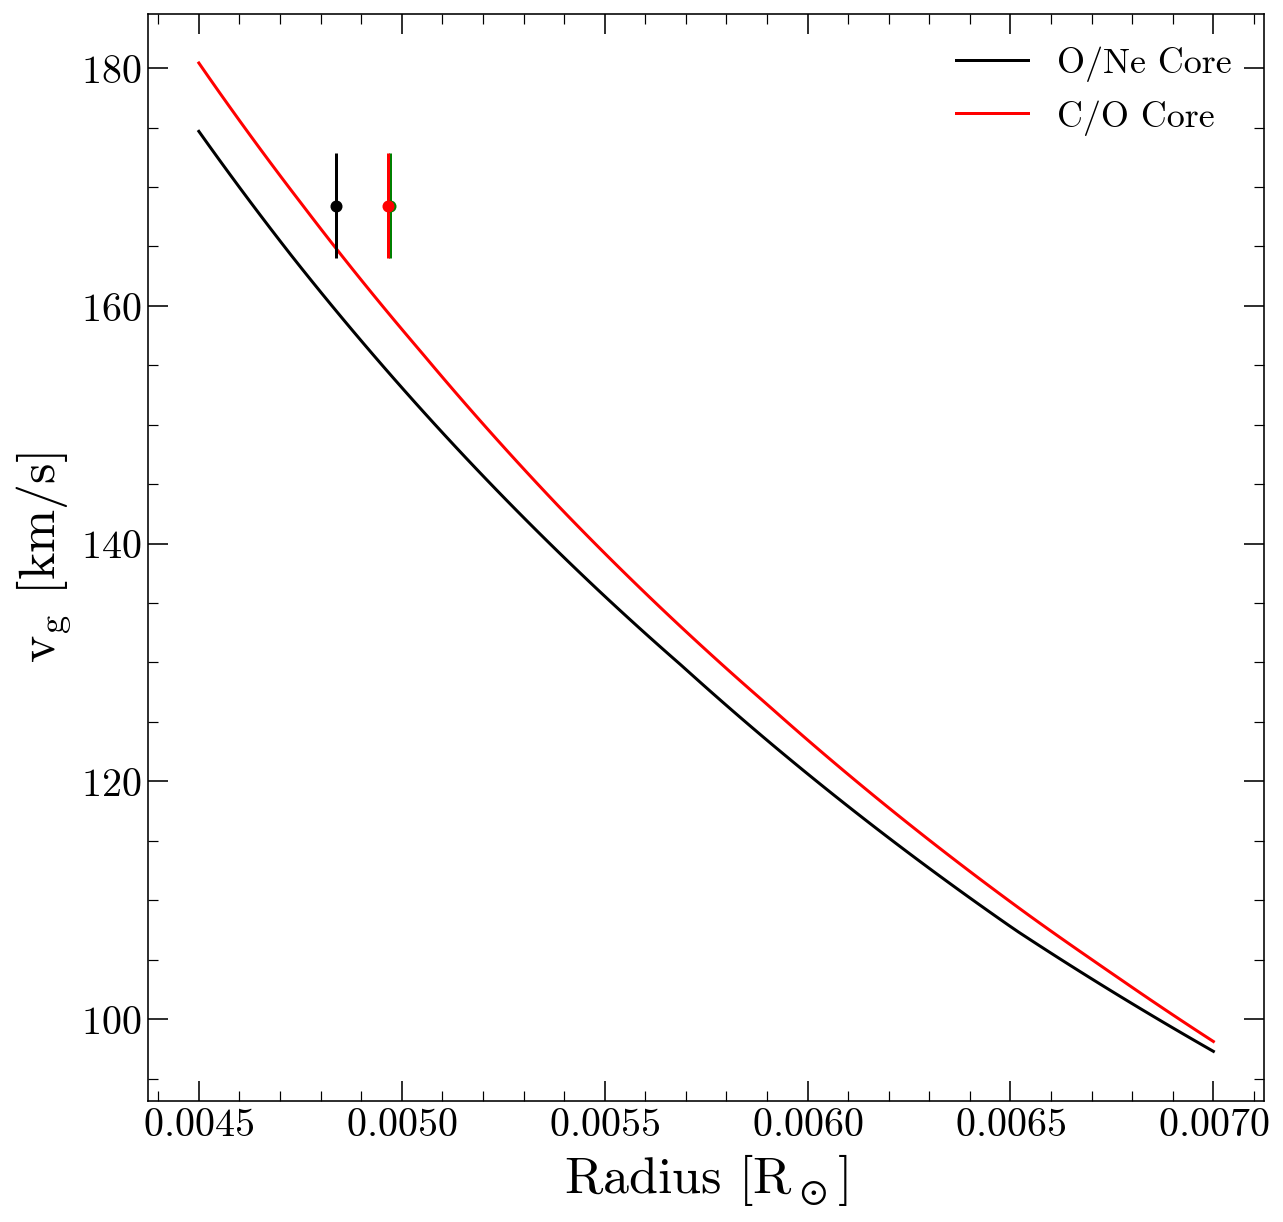

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(rad_array, vg_array_one, label='O/Ne Core', color = 'k')
plt.plot(rad_array, vg_array_co, label='C/O Core', color = 'red')

plt.errorbar(catalog['radius'][indx], gz_rv, xerr = catalog['e_radius'][indx], yerr = e_gz_rv, fmt = 'o', color='black', ecolor = 'black')
#plt.errorbar(catalog['fontaine_radius'][indx], gz_rv, xerr = catalog['e_radius'][indx], yerr = e_gz_rv, fmt = 'o', color='green', ecolor = 'green')
#plt.errorbar(catalog['camissa_radius'][indx], gz_rv, xerr = catalog['e_radius'][indx], yerr = e_gz_rv, fmt = 'o', color='red', ecolor = 'red')

plt.xlabel('Radius $[R_\odot]$')
plt.ylabel('$v_g$ $[km/s]$')

plt.legend(framealpha=0)

In [ ]:
print(e_gz_rv)

radial_velocity_error
---------------------
    4.404510976267387
